In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

In [2]:
plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-colorblind')

plt.rcParams['figure.figsize'] = [16,9]
# plt.rcParams['legend.fontsize'] = "LARGE"
plt.rcParams.update({'font.size': 24})

In [3]:
def toGiB(df, column):
    df[column] = df[column] / 2**30

In [4]:
def prepare_metrics(df):
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    for column in [
        "gpu_memory_total",
        "gpu_memory_reserved",
        "gpu_memory_free",
        "gpu_memory_used",
        "host_memory_total",
        "host_memory_used",
        "host_memory_free",
        "swap_memory_total",
        "swap_memory_used",
        "swap_memory_free",
    ]:
        toGiB(df, column)
    df["power"] = df["power"] / 1_000 # convert mW to W

In [5]:
def prepare_data(df):
    df["oom"] = df["accuracy"] == "out of memory"
    df.loc[df["accuracy"] == "out of memory","accuracy"] = np.nan
    df["accuracy"] = pd.to_numeric(df["accuracy"])
    df["dead_kernels"] = df["dead_kernels"].apply(json.loads)
    df.index += 1
    return df

In [6]:
def prepare_data2(df):
    df["oom"] = df["accuracy"] == "out of memory"
    df.loc[df["accuracy"] == "out of memory","accuracy"] = np.nan
    df.loc[df["accuracy"] == "kernel died","accuracy"] = np.nan
    df["accuracy"] = pd.to_numeric(df["accuracy"])
    df["dead_kernels"] = df["dead_kernels"].apply(json.loads)
    df["start"] = pd.to_datetime(df["start"])
    df["end"] = pd.to_datetime(df["end"])
    df["external_start"] = pd.to_datetime(df["external_start"])
    df["external_end"] = pd.to_datetime(df["external_end"])
    df["duration"] = (df["end"] - df["start"]).apply(lambda x: x.total_seconds())
    df["external_duration"] = (df["external_end"] - df["external_start"]).apply(lambda x: x.total_seconds())
    df["all_alive"] = df["dead_kernels"].apply(len) == 0

    df.index += 1
    return df

In [7]:
dataset_paths = {
    # "baseline": "results/baseline-6.csv",
    "baseline": "results/baseline-cleared-cache.csv",
    "nvshare": "results/nvshare-cleared-cache.csv",
    "ersa": "results/ersa-7.csv"
}

# dataset_paths = {
#     "baseline": "results/resnet_baseline.csv",
#     "nvshare": "results/resnet_nvshare.csv",
#     "ersa": "results/resnet_ersa.csv"
# }
dataset_paths = {key:Path(value) for key,value in dataset_paths.items()}
metrics_paths = {key:value.with_suffix(".metrics.csv") for key,value in dataset_paths.items()}
datasets = {key:pd.read_csv(path,index_col=0) for key,path in dataset_paths.items()}
metrics = {key:pd.read_csv(path, index_col=0) for key,path in metrics_paths.items()}

for dataset in datasets.values():
    prepare_data2(dataset)

for metric in metrics.values():
    prepare_metrics(metric)

In [8]:
dataset=datasets["nvshare"]
dataset[dataset["all_alive"] == False].first_valid_index()
#dataset.loc[dataset[dataset["all_alive"] == False].first_valid_index()].start

In [9]:
def plot_memory_usage(metrics, datasets, key):
    metric = metrics[key]
    dataset = datasets[key]

    plot_args = {"markersize": 10, "linewidth": 5}
    
    label = None
    if dataset["oom"].any():
        start = dataset.loc[dataset[dataset["oom"]].first_valid_index()].start
        label = "OOM"
    else:
        start = dataset.iloc[-1].end
    
    if (dataset["all_alive"] == False).any():
        label = "kernels died"
        start = dataset.loc[dataset[dataset["all_alive"] == False].first_valid_index()].start

    error_linestyle = ":"

    ax = plt.subplot()
    plot_args["ax"] = ax
    plot_args["color"] = next(ax._get_lines.prop_cycler)['color']
    metric[metric["timestamp"] < start].set_index("timestamp")["gpu_memory_used"].plot(label="VRAM", **plot_args)
    metric[metric["timestamp"] > start].set_index("timestamp")["gpu_memory_used"].plot(label="", linestyle=error_linestyle, **plot_args)

    plot_args["color"] = next(ax._get_lines.prop_cycler)['color']
    metric[metric["timestamp"] < start].set_index("timestamp")["host_memory_used"].plot(label="DRAM", **plot_args)
    metric[metric["timestamp"] > start].set_index("timestamp")["host_memory_used"].plot(label="",linestyle=error_linestyle, **plot_args)
    
    plot_args["color"] = next(ax._get_lines.prop_cycler)['color']
    metric[metric["timestamp"] < start].set_index("timestamp")["swap_memory_used"].plot(label="SWAP", **plot_args)
    metric[metric["timestamp"] > start].set_index("timestamp")["swap_memory_used"].plot(label="", linestyle=error_linestyle, **plot_args)

    if label is not None:
        plt.plot([],[],color="black",linestyle=error_linestyle,label=label,linewidth=5)


    
    # metric.set_index("timestamp")["cpu_util"].plot()
    # metric.set_index("timestamp")["power"].plot()
    # if dataset["oom"].any():
    #     start = dataset.loc[dataset[dataset["oom"]].first_valid_index()].start
    #     end = dataset.loc[dataset["oom"].last_valid_index()].end
    #     plt.axvspan(start, end, alpha=0.2, facecolor="#CC5500", label="OOM")

    # if (dataset["all_alive"] == False).any():
    #     start = dataset.loc[
    #         dataset[dataset["all_alive"] == False].first_valid_index()
    #     ].start
    #     end = dataset.loc[dataset[dataset["all_alive"] == False].last_valid_index()].end
    #     plt.axvspan(start, end, alpha=0.2, facecolor="#0055CC", label="kernels died")

    plt.xticks(dataset["start"].iloc[::4], dataset.index[::4])
    plt.xticks(dataset["start"], minor=True)
    plt.tick_params(reset=True, axis="x", rotation=0)
    plt.xlim((dataset["start"].iloc[0], dataset["start"].iloc[-1]))
    plt.xlabel("# of Users")
    plt.ylabel("Memory Usage [GiB]")
    plt.legend()
    plt.ylim(bottom=0,top=metric.iloc[0]["host_memory_total"])
    plt.title(f"Memory Usage [{key}]")

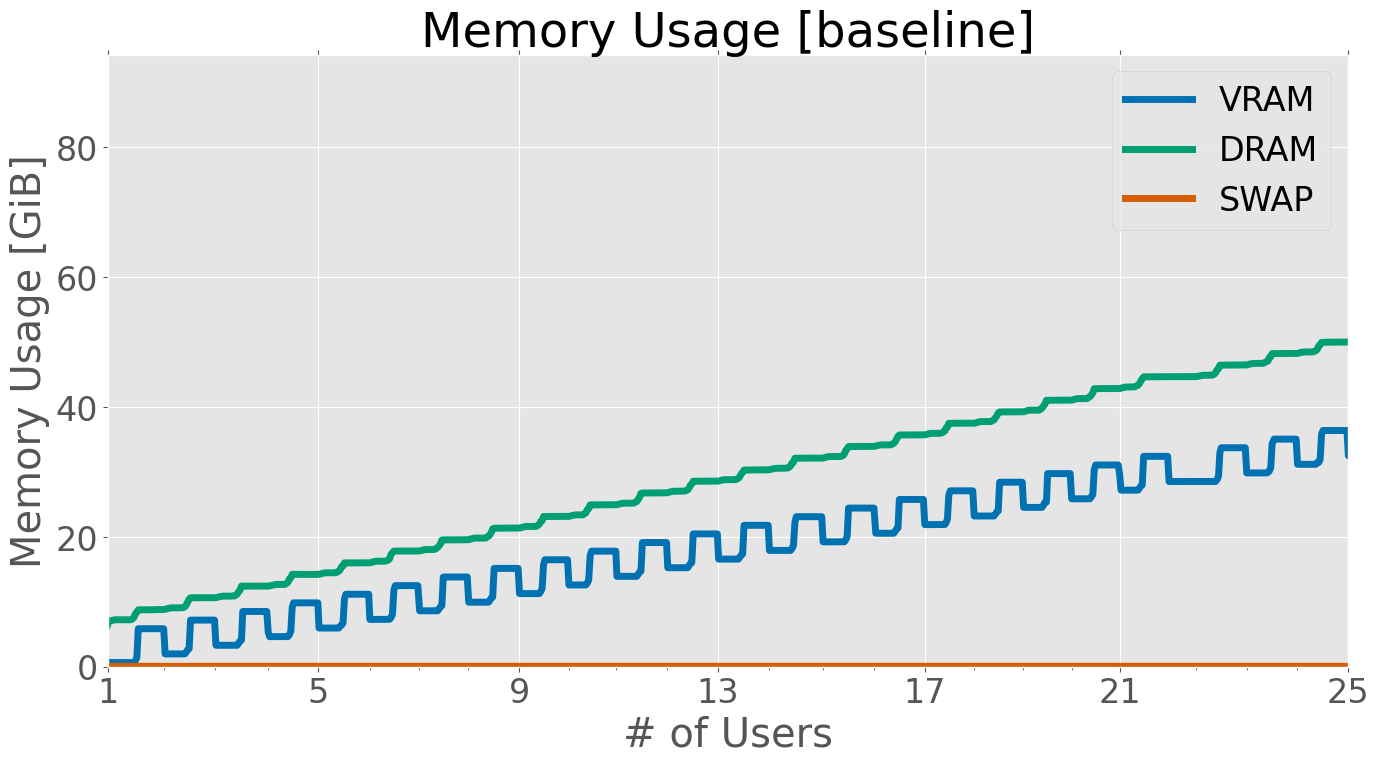

In [10]:
plot_memory_usage(metrics, datasets, "baseline")
plt.savefig("validation/memory-usage-baseline.pdf")

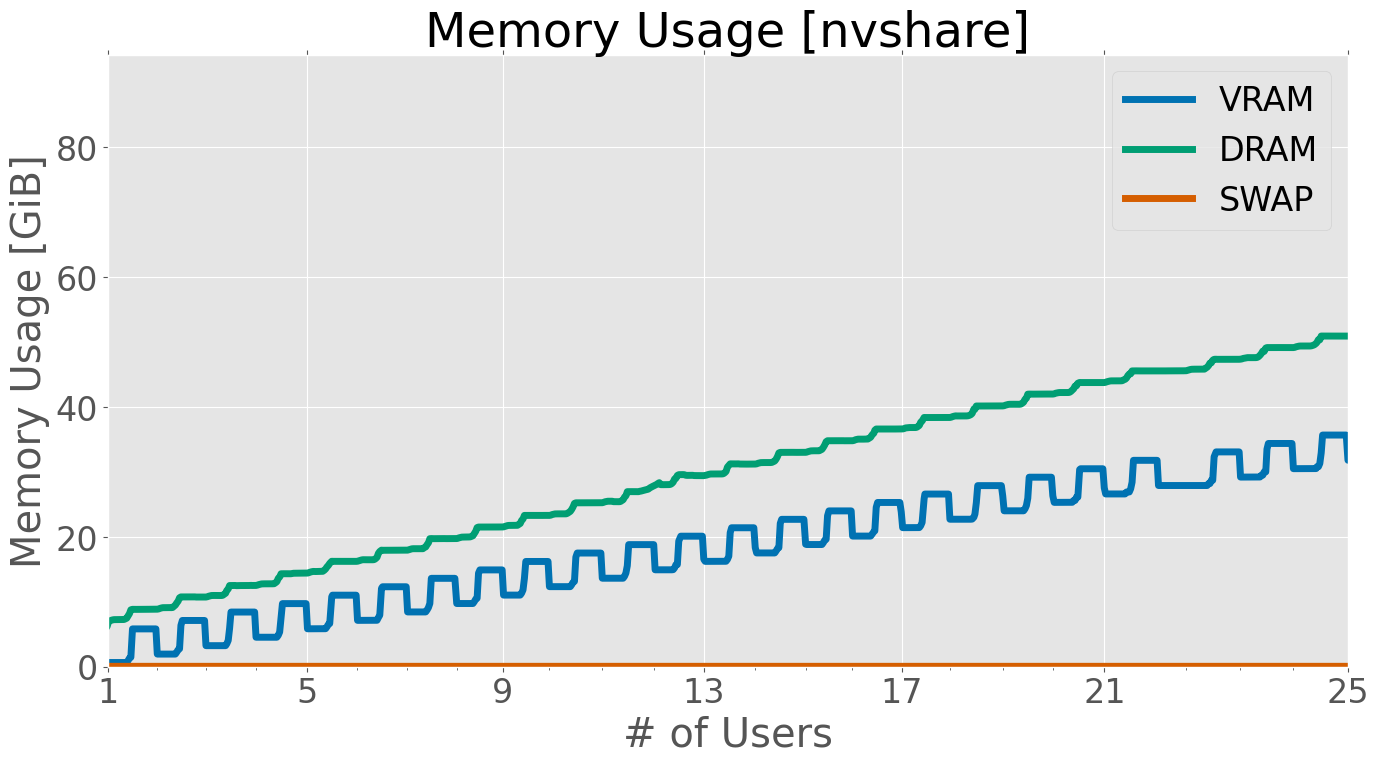

In [11]:
plot_memory_usage(metrics, datasets, "nvshare")
plt.savefig("validation/memory-usage-nvshare.pdf")

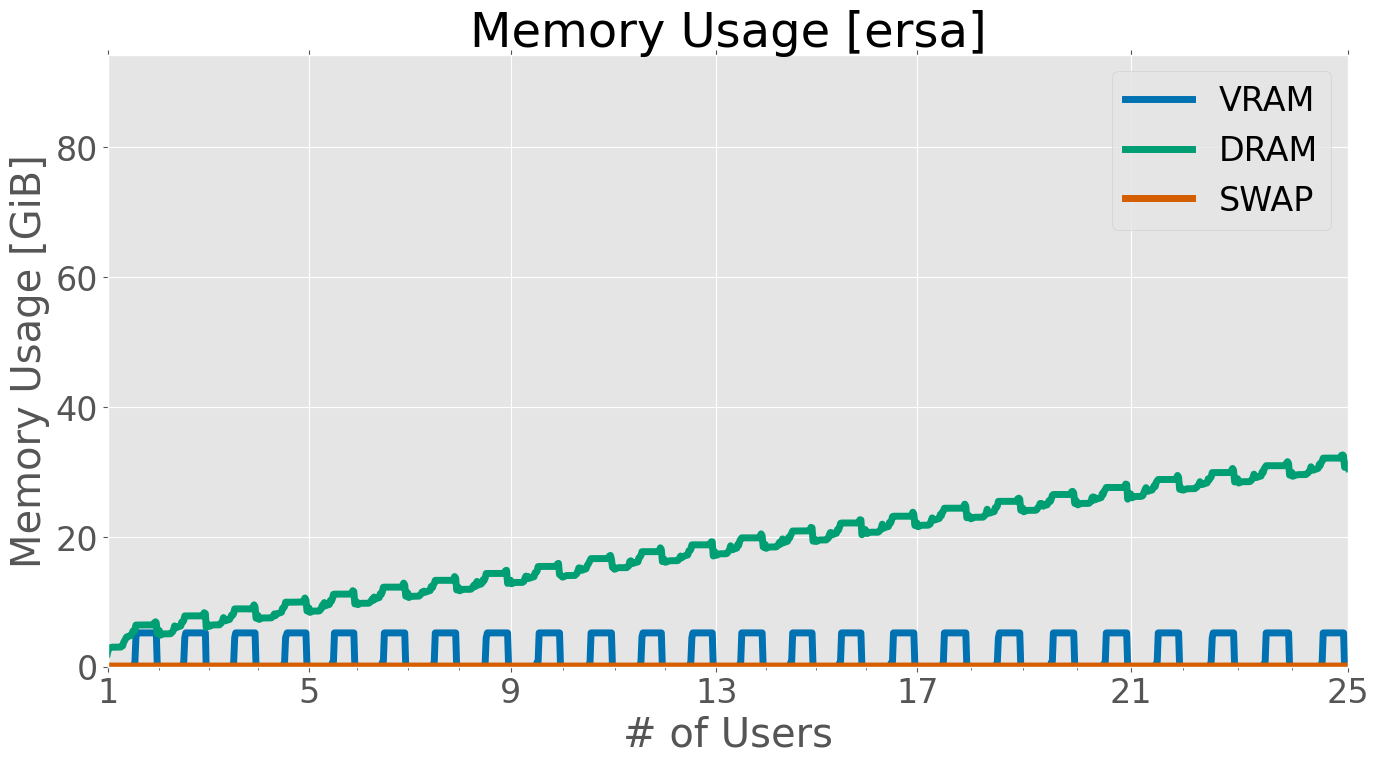

In [12]:
plot_memory_usage(metrics, datasets, "ersa")
plt.savefig("validation/memory-usage-ersa.pdf")

In [13]:
def plot_duration(datasets, condition, key, marker="o", label=None,**kwargs):
    df = datasets[key]
    if label is None:
        label = key

    if not "markersize" in kwargs:
        kwargs["markersize"] = 10
    
    if not "linewidth" in kwargs:
        kwargs["linewidth"] = 5

    return df.query(condition)["duration"].plot(marker=marker, label=label, **kwargs)

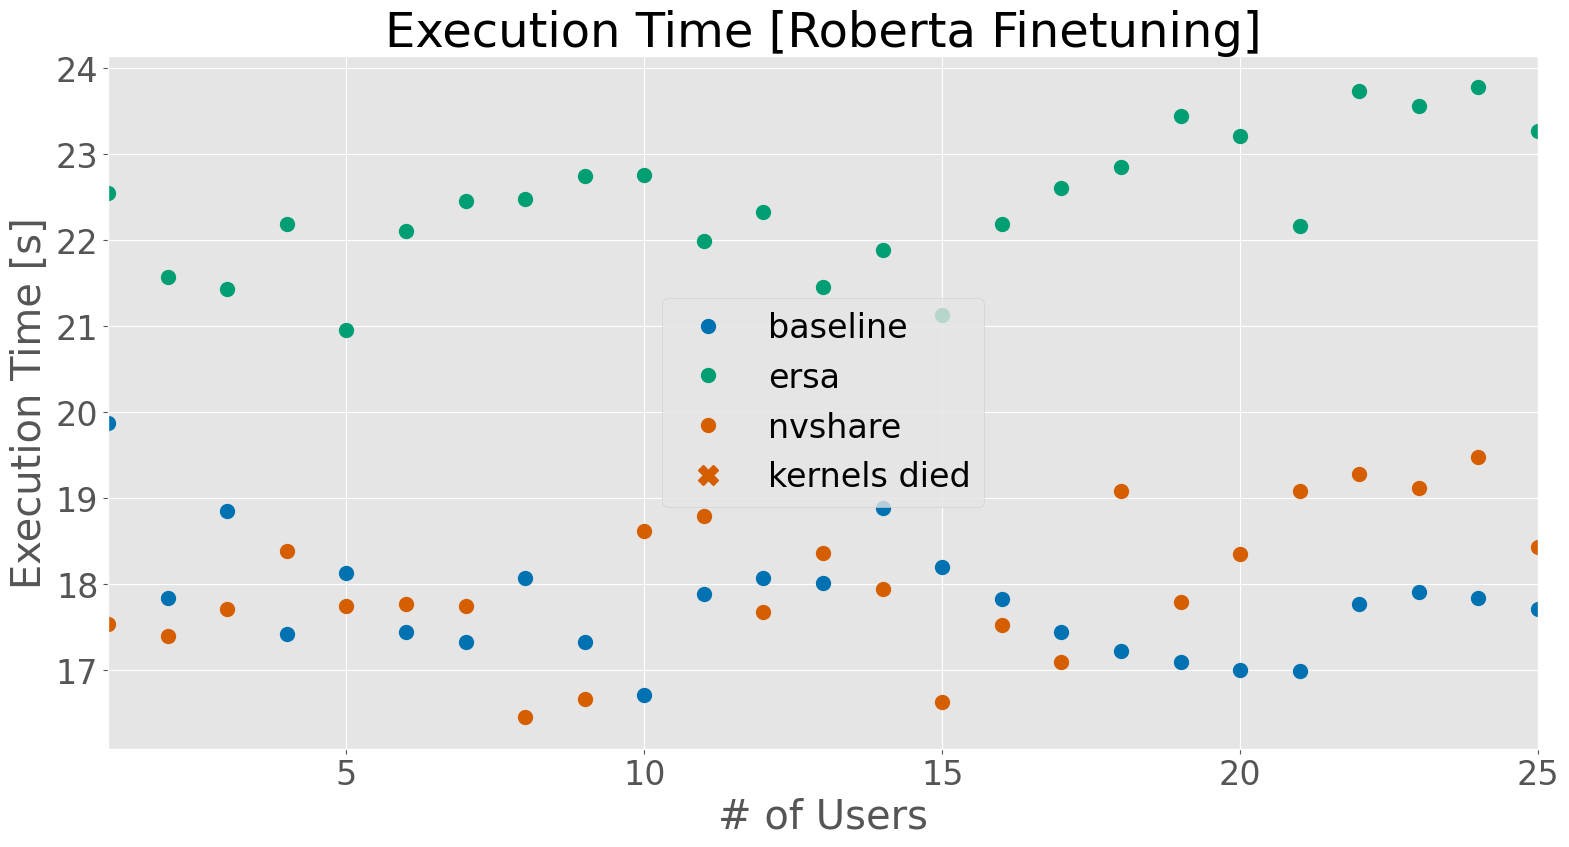

In [14]:
plot_duration(datasets,"oom == False", "baseline", linewidth=0)
ax = plot_duration(datasets,"oom == False", "ersa", linewidth=0)

color = next(ax._get_lines.prop_cycler)['color']

plot_duration(datasets,"oom == False & all_alive == True", "nvshare", color=color, linewidth=0)

plot_duration(datasets,"oom == False & all_alive == False", "nvshare", label="kernels died", marker="X", markersize=15, color=color, linewidth=0)

#plot_duration(datasets, "all_alive == True", "nvshare", marker="o", label="", markersize=12, linewidth=0, color=color)
#plot_duration(datasets, "all_alive == False", "nvshare", marker="X", label="kernels died", markersize=15, linewidth=5, color=color,linestyle="dotted")

plt.title("Execution Time [Roberta Finetuning]")
plt.xlabel("# of Users")
plt.ylabel("Execution Time [s]")
plt.legend()
plt.tight_layout()
plt.xlim((1, max((len(x) for x in datasets.values()))))
plt.savefig("validation/execution-time-roberta-finetuning.pdf")

In [15]:
(datasets["ersa"][baseline_range]["duration"].mean() - datasets["baseline"][baseline_range]["duration"].mean()) / datasets["baseline"][baseline_range]["duration"].mean()

NameError: name 'baseline_range' is not defined

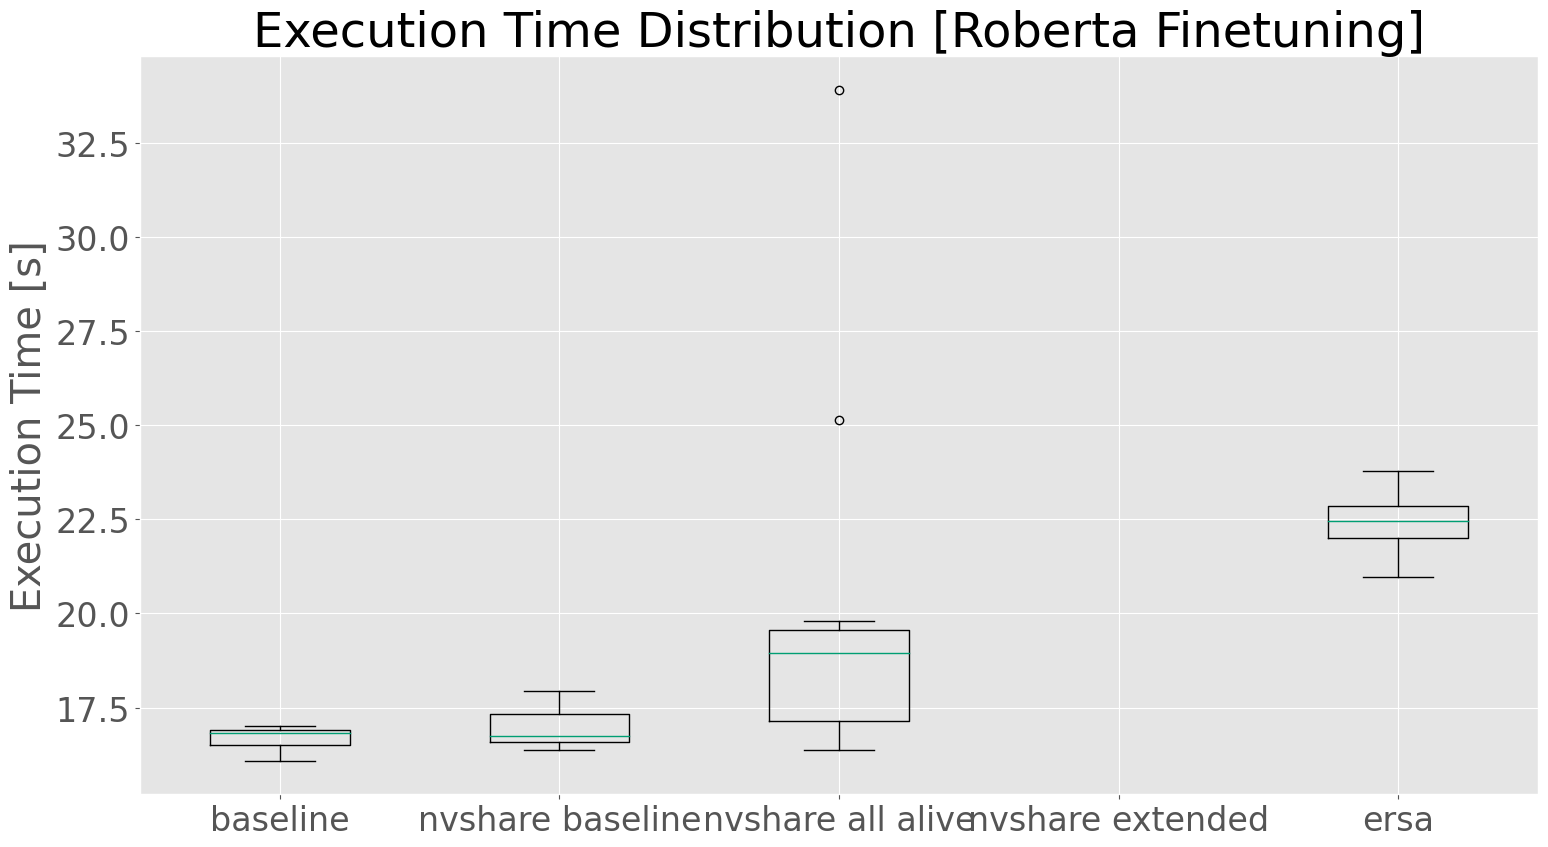

In [ ]:
baseline_range = datasets["baseline"]["oom"] == False
alive_range = datasets["nvshare"]["all_alive"] == True

boxplot_data = {
    "baseline": datasets["baseline"][baseline_range]["duration"],
    "nvshare baseline": datasets["nvshare"][baseline_range]["duration"],
    "nvshare all alive": datasets["nvshare"][alive_range]["duration"],
    "nvshare extended": datasets["nvshare"][~baseline_range]["duration"],
    "ersa": datasets["ersa"]["duration"]
}

plt.boxplot(boxplot_data.values(), labels=boxplot_data.keys());
plt.title("Execution Time Distribution [Roberta Finetuning]")
plt.ylabel("Execution Time [s]")
plt.tight_layout()
plt.savefig("validation/execution-time-distribution-roberta-finetuning.pdf")

In [ ]:
pd.DataFrame(boxplot_data).mean()["nvshare all alive"] - pd.DataFrame(boxplot_data).mean()["baseline"]

2.6828845999999977

In [ ]:
pd.DataFrame(boxplot_data).mean()["nvshare baseline"] - pd.DataFrame(boxplot_data).mean()["baseline"]

0.28902137499999725

In [ ]:
pd.DataFrame(boxplot_data).mean()["ersa"] - pd.DataFrame(boxplot_data).mean()["baseline"]

5.764340260000001

In [ ]:
((pd.DataFrame(boxplot_data).mean()["nvshare baseline"] / pd.DataFrame(boxplot_data).mean()["baseline"]) - 1) * 100

1.7334596026274518

In [ ]:
baseline["duration"].plot()
nvshare["duration"].plot()
plt.axvspan(baseline[baseline["oom"] == False].last_valid_index(),baseline["oom"].last_valid_index(), alpha=0.2, facecolor="#CC5500", label="OOM")

plt.legend()

NameError: name 'baseline' is not defined

In [ ]:
df[df["oom"] == False]["duration"].plot.box()

NameError: name 'df' is not defined